# Incomplete Markets. General Equilibrium

In [7]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

rho=0.06
sigma=2
c_bar=100
gamma=0.8
sigma_y=0.8
y=1.2
beta=1/(1+rho)
Y1 = np.array([y-sigma_y, y+sigma_y])
PI1 = [[(1+gamma)/2, (1-gamma)/2], [(1-gamma)/2, (1+gamma)/2]]
n=100
epsilon=0.05
Amax=20
omega = -111111111111111
alpha = 0.33                # Following Ayagari
delta=0.08                  # Following Ayagari


#Amin = round(-min(Y1)*((1+r)/r))+3
Amin = 0

grid = np.linspace(Amin,Amax,n)

def find_values(g):
    
    ''' This function returns the value of capital and the wage for a given
    interest rate, using the FOC of the firms.'''
    
    k = ((g+delta)/alpha)**(1/(alpha-1))
    
    w = (1-alpha) * k**(alpha)
    
    return k,w


def utility (a0,a1,w,y,r):
    
    ''' This function retunrs the utility under CRRA preferences'''
    
    c = w*y+a0*(1+r)-a1
   
    if c>=0: 
        
        u = (((c)**(1-sigma)-1)/(1-sigma))
            
    else:
        u=omega
    return u


def feasible(a0,y,w,r):
    "Returns the maximum feasible k_j given k_i with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
    f = w*y+(1+r)*a0
    return f


def VFI_Uncertainty(M,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
       
    X = np.zeros(shape=(n*len(Y1),n))
            
    V= np.zeros(shape=(1,n*len(Y1)))
            
    Vnew = np.zeros(shape=(1,n*len(Y1)))
    
    g = np.zeros(shape=(1,n*len(Y1)))      # Array for optimal decision rule

            
    W = np.zeros(shape=(1,n*len(Y1)))
            
    # Get the max of all the possible X[j] = M + betaV given j, assuming the initial guess is V=0:
            
    for i in range(n*len(Y1)):
        Vnew[0][i] = np.amax(M[i][:])
        g[0][i] = np.argmax(X[i][:])        # The optimal decision rule
                
        # Generate the new value function and repeat the process until tolerance is satisfied:   
            
                
    while np.any(abs(V-Vnew)>=epsilon):
        V = Vnew.copy()
        for i in range(n*len(Y1)):
            if i<=n-1:
                Z = np.array([Vnew[0][i] , Vnew[0][i+n]])
                        
                W[0][i] = np.inner(PI1[0] , Z)
                        
            else: 
                Z = np.array([Vnew[0][i-n] , Vnew[0][i]])
                        
                W[0][i] = np.inner(PI1[1] , Z)     
         
        for x in range(len(Y1)):
            for i in range(n):
                for j in range(n):
                    X[i+n*x][j] = M[i+n*x][j] + beta*W[0][j+n*x]
                
        for i in range(n*len(Y1)):
            Vnew[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])      
            
                           
    return V , g




def gen_M(Y1,w,r):
    
    '''This function generates the matrix M with all the feasible
    utiilty levels given combinations of assets'''
    
    M = np.zeros(shape=(n*len(Y1),n))
            
    for x in range(len(Y1)):
        for i in range(n):
            for j in range(n):
                if feasible(grid[i],Y1[x],w,r) >= grid[j]: 
                    M[i+n*x][j] = utility(grid[i],grid[j],w,Y1[x],r) # Gives the element ij of matrix M
                else: 
                    M[i+n*x][j] = omega
    return M


def find_nearest(array, value):
    
    '''This function takes the nearest feasible value in a grid. Takes as a input a value
    that might not be in the grid, and returns the nearest value in that grid.'''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

   
# Find the invariant distribution of assets: 
  
def assets_path_random_new(grid,policy,initial_assets,T,Y,PI):
    
    ''' This function returns the level of assets for an individual after T periods
    facing income shocks every period according to the transition matrix PI.'''
    
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    g = find_nearest(grid,initial_assets)
    
    a = np.random.binomial(1,8/10)

    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i>0:
        
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,PI[1][1])
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,PI[0][1])
   
    lastasset = grid[c]
        
    
    return lastasset
    


def find_stationary_new(policy,Y,PI,periods,individuals,grid,initial_assets):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random_new(grid,policy,initial_assets,periods,Y,PI)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati

   
    
def frequency(x):
    
    ''' This function computes the frequency of each value of the stationary 
    distribution. This is a key step to later compute the total amount of assets'''
    
    output = []
    for i in x:
        if i not in output:
            output.append(i)
            
    frec = np.zeros(shape=(len(output),2))
    
    a=0
    
    for i in output:
        
        c = find_nearest(grid, i)
        
        frec[a][0] = np.count_nonzero(x==c)/len(x)
        frec[a][1] = i
        
        a+=1
    
    return frec



def Ea(sta,policy):
    
    '''This function computes the supply of demand for a given
    level of interest rate'''
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    val = sta[:,1]
    freq = sta[:,0]
    
    E = np.zeros(len(val))
    
    for i in range(len(val)):
        
        E[i] = val[i] * freq[i]
        
    Ea = sum(E)
    
    return Ea

       
        
    

def solve():
    
    '''This function iterates all the economy for different values of 
    interest rates to find the path of supply of assets.'''
    
    grid_r = np.linspace(-delta+0.01,rho,20)
       
    Ea_path = np.zeros(len(grid_r))
    
    for i in range(len(grid_r)):
        
        r = grid_r[i]
        
        k,w = find_values(r)
        
        M = gen_M(Y1,w,r)
        
        ValueFunction, Policy = VFI_Uncertainty(M,epsilon)
        
        stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
        values = frequency(stationary)
        
        EAss = Ea(values,Policy)
               
        Ea_path[i] = EAss
        
    return Ea_path

def capital_to_r(sup):
    
    '''This funciton returs the interest rate associated to a given
    demand of assets using the FOC of the firms.'''
    
    dem = alpha*sup**(alpha-1)-delta
    
    return dem



In [8]:
qe.tic()   
eapath = solve()
qe.toc()  
 

TOC: Elapsed: 0:09:37.19


577.1923403739929

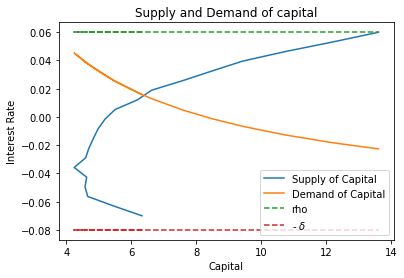

In [13]:
#  Plot the results:

r_space = np.linspace(-delta+0.01,rho,20)

demand = capital_to_r(eapath)

fig, ax = plt.subplots()
ax.plot(eapath,r_space,label='Supply of Capital')
ax.plot(eapath,demand,label='Demand of Capital')
ax.plot(eapath,rho*np.ones(20),'--',label='rho')
ax.plot(eapath,-delta*np.ones(20),'--',label='- $\delta$')
plt.ylabel('Interest Rate')
plt.xlabel('Capital')
plt.title('Supply and Demand of capital')
plt.legend() 


In [14]:
# Now I need to find the value at which supply and demand cross. This will be the recursive stationary competitive 
# equilibrium since all the markets will clear there. 


# I will now compute the value of the interest rate that is minimizing those two curves. 

z1 = [abs(demand-r_space)]

a = np.argmin(z1)

r_demand = demand[a]
r_supply = r_space[a]



In [15]:
def solve(grid_r):
    
    '''This function iterates all the economy for different values of 
    interest rates to find the path of supply of assets.'''
       
    Ea_path = np.zeros(len(grid_r))
    
    for i in range(len(grid_r)):
        
        r = grid_r[i]
        
        k,w = find_values(r)
        
        M = gen_M(Y1,w,r)
        
        ValueFunction, Policy = VFI_Uncertainty(M,epsilon)
        
        stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
        values = frequency(stationary)
        
        EAss = Ea(values,Policy)
               
        Ea_path[i] = EAss
        
    return Ea_path

def find(w1,w2,epsilon):
    
    supply=1
    demand=0
    
    k_demand = np.zeros(20)
    
    r1=w1
    r2=w2
    
    while abs(supply-demand)>epsilon:
        r_val = np.linspace(r1,r2,20)
        k_supply = solve(r_val)
        for i in range(len(k_supply)):
            k_demand[i] = find_values(r_val[i])[0]
        
        a = np.argmin(abs(k_demand-k_supply))
        
        r = r_val[a]
        
        demand = k_demand[a]
        supply = k_supply[a]
        
        if a ==0:
            
            r1 = r_val[0]-0.03
            r2 = r_val[5]
        if a==19:
            
            r1= r_val[13]
            r2=r_val[19]+0.03
        else:
            r1=r_val[a-3]
            r2=r_val[a+3]
        
    return r


In [16]:
r_min = find(r_demand,r_supply,0.5)   # I put a big tolerance to improve the computational speed. 

In [53]:
 print(r_min)

0.014831686376578024


(array([283.,  57.,  72.,  44.,  60.,  55.,  48.,  44.,  44.,  60.,  46.,
         73.,  48.,  52.,  63.,  44.,  54.,  64.,  55.,  45.,  55.,  37.,
         53.,  46.,  45.,  46.,  43.,  42.,  38.,  29.,  19.,  48.,  29.,
         33.,  16.,  23.,  18.,  14.,   8.,  47.]),
 array([ 0.        ,  0.40909091,  0.81818182,  1.22727273,  1.63636364,
         2.04545455,  2.45454545,  2.86363636,  3.27272727,  3.68181818,
         4.09090909,  4.5       ,  4.90909091,  5.31818182,  5.72727273,
         6.13636364,  6.54545455,  6.95454545,  7.36363636,  7.77272727,
         8.18181818,  8.59090909,  9.        ,  9.40909091,  9.81818182,
        10.22727273, 10.63636364, 11.04545455, 11.45454545, 11.86363636,
        12.27272727, 12.68181818, 13.09090909, 13.5       , 13.90909091,
        14.31818182, 14.72727273, 15.13636364, 15.54545455, 15.95454545,
        16.36363636]),
 <a list of 40 Patch objects>)

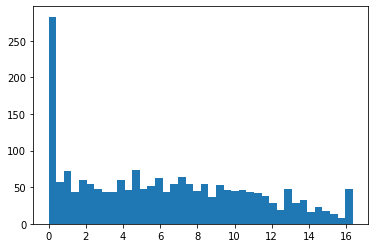

In [17]:
# Compute the histogram of the stationary distribution:

k,w = find_values(r_min)
        
M = gen_M(Y1,w,r_min)
        
ValueFunction, Policy = VFI_Uncertainty(M,epsilon)
        
stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
values = frequency(stationary)
        
ksupplied = Ea(values,Policy)

   


Text(0, 0.5, 'Frequency')

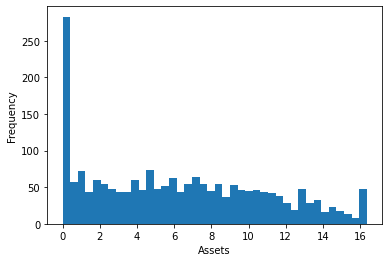

In [50]:
plt.hist(stationary,bins=40)
plt.xlabel('Assets')
plt.ylabel('Frequency')

## Compute the Stats of Inequality:

In [20]:
 # Generate a function that will compute the share of assets owned by each percentile. 
from tabulate import tabulate

def percentile(values,percent,top):
    
    '''This function takes as inputs the percentile to be computed and the stationary distribution
    of assets and returns the share of assets owned by this percentile'''
    
    ordered = sorted(values)                 # Order the assets owned in the economy
    
    
    if top==False:
        
        x = np.int(len(values)*(percent/100))    # The interval [0,x] is the agents that belong to percent.
        
        share = sum(ordered[:x])/sum(ordered)
    
    else: 
       
        x = np.int(len(values)*(1-(percent)/100))    # The interval [0,x] is the agents that belong to percent.
        
        share = sum(ordered[x:])/sum(ordered)
           
    return share

top1 =  percentile(stationary,1,top=True)
top10 =  percentile(stationary,10,top=True)
bottom50 =  percentile(stationary,50,top=False)

print('The top 1% has '+str(round(top1*100,2))+'% of wealth of the economy')
print('The top 10% has '+str(round(top10*100,2))+'% of wealth of the economy')
print('The bottom 50% has '+str(round(bottom50*100,2))+'% of wealth of the economy')
 

Q1 = percentile(stationary,20,top=False)
Q2 = percentile(stationary,40,top=False) - percentile(stationary,20,top=False)
Q3 = percentile(stationary,60,top=False) - percentile(stationary,40,top=False)
Q4 = percentile(stationary,80,top=False) - percentile(stationary,60,top=False)
Q5 = percentile(stationary,20,top=True)

print('Q1 '+str(round(Q1*100,2))+'% of wealth of the economy')
print('Q2 '+str(round(Q2*100,2))+'% of wealth of the economy')
print('Q3 '+str(round(Q3*100,2))+'% of wealth of the economy')
print('Q4 '+str(round(Q4*100,2))+'% of wealth of the economy')
print('Q5 '+str(round(Q5*100,2))+'% of wealth of the economy')

The top 1% has 2.63% of wealth of the economy
The top 10% has 23.48% of wealth of the economy
The bottom 50% has 18.25% of wealth of the economy
Q1 1.0% of wealth of the economy
Q2 8.99% of wealth of the economy
Q3 18.9% of wealth of the economy
Q4 28.76% of wealth of the economy
Q5 42.36% of wealth of the economy


# Compute the distribution T periods after Covid Shock, starting from the stationary distribution.



In [28]:
def assets_path_random_new_covid(grid,policy,initial_assets,T,Y,PI,period_shock,phigh_low,phigh_high):
    
    ''' This function returns the level of assets for an individual after T periods
    facing income shocks every period according to the transition matrix PI.'''
    
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    g = find_nearest(grid,initial_assets)
    
    a = np.random.binomial(1,8/10)

    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i == period_shock:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
            
            
        
        else:
        
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,PI[1][1])
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,PI[0][1])
   
    lastasset = grid[c]
        
    
    return lastasset
    


def find_stationary_new_covid(policy,Y,PI,periods,individuals,grid,initial_assets,period_shock,phigh_high,phigh_low):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random_new_covid(grid,policy,initial_assets,periods,Y,PI,period_shock,phigh_high,phigh_low)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati

In [54]:
# Compute the stationary distribution

stationary_covid = find_stationary_new_covid(Policy,Y1,PI1,2000,2000,grid,3,1998,0,0)   # In the last period everybody gets low productivity


Text(0, 0.5, 'Frequency')

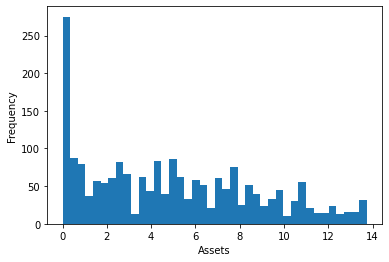

In [55]:
# Plot the distribution:

plt.hist(stationary_covid,bins=40)
plt.xlabel('Assets')
plt.ylabel('Frequency')


In [56]:
# Compute the statistics:

top1_covid =  percentile(stationary_covid,1,top=True)
top10_covid=  percentile(stationary_covid,10,top=True)
bottom50_covid =  percentile(stationary_covid,50,top=False)

print('The top 1% has '+str(round(top1_covid*100,2))+'% of wealth of the economy')
print('The top 10% has '+str(round(top10_covid*100,2))+'% of wealth of the economy')
print('The bottom 50% has '+str(round(bottom50_covid*100,2))+'% of wealth of the economy')
 

Q1_covid = percentile(stationary_covid,20,top=False)
Q2_covid = percentile(stationary_covid,40,top=False) - percentile(stationary_covid,20,top=False)
Q3_covid = percentile(stationary_covid,60,top=False) - percentile(stationary_covid,40,top=False)
Q4_covid = percentile(stationary_covid,80,top=False) - percentile(stationary_covid,60,top=False)
Q5_covid = percentile(stationary_covid,20,top=True)

print('Q1 '+str(round(Q1_covid*100,2))+'% of wealth of the economy')
print('Q2 '+str(round(Q2_covid*100,2))+'% of wealth of the economy')
print('Q3 '+str(round(Q3_covid*100,2))+'% of wealth of the economy')
print('Q4 '+str(round(Q4_covid*100,2))+'% of wealth of the economy')
print('Q5 '+str(round(Q5_covid*100,2))+'% of wealth of the economy')

The top 1% has 2.79% of wealth of the economy
The top 10% has 24.56% of wealth of the economy
The bottom 50% has 17.12% of wealth of the economy
Q1 0.86% of wealth of the economy
Q2 8.28% of wealth of the economy
Q3 18.22% of wealth of the economy
Q4 28.72% of wealth of the economy
Q5 43.92% of wealth of the economy


# Suppose now Covid Lasts More Periods. 

In [57]:
def assets_path_random_longcovid(grid,policy,initial_assets,T,Y,PI,period_shock,phigh_low,phigh_high):
    
    ''' This function returns the level of assets for an individual after T periods
    facing income shocks every period according to the transition matrix PI.'''
    
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    g = find_nearest(grid,initial_assets)
    
    a = np.random.binomial(1,8/10)

    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i == period_shock:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
        
        if i == period_shock+1:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
            
        if i == period_shock+2:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
            
            
        
        else:
        
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,PI[1][1])
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,PI[0][1])
   
    lastasset = grid[c]
        
    
    return lastasset
    


def find_stationary_longcovid(policy,Y,PI,periods,individuals,grid,initial_assets,period_shock,phigh_high,phigh_low):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random_new_covid(grid,policy,initial_assets,periods,Y,PI,period_shock,phigh_high,phigh_low)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati

In [58]:
# Compute the distribution: 

stationary_longcovid = find_stationary_longcovid(Policy,Y1,PI1,2000,2000,grid,3,1995,0,0)   # In the last period everybody gets low productivity



Text(0, 0.5, 'Frequency')

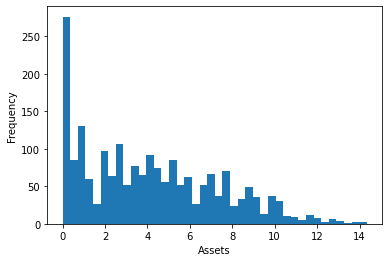

In [59]:
# Plot the distribution:

plt.hist(stationary_longcovid,bins=40)
plt.xlabel('Assets')
plt.ylabel('Frequency')

In [60]:
# Compute the statistics:

top1_longcovid =  percentile(stationary_longcovid,1,top=True)
top10_longcovid=  percentile(stationary_longcovid,10,top=True)
bottom50_longcovid =  percentile(stationary_longcovid,50,top=False)

print('The top 1% has '+str(round(top1_longcovid*100,2))+'% of wealth of the economy')
print('The top 10% has '+str(round(top10_longcovid*100,2))+'% of wealth of the economy')
print('The bottom 50% has '+str(round(bottom50_longcovid*100,2))+'% of wealth of the economy')
 

Q1_longcovid = percentile(stationary_longcovid,20,top=False)
Q2_longcovid = percentile(stationary_longcovid,40,top=False) - percentile(stationary_longcovid,20,top=False)
Q3_longcovid = percentile(stationary_longcovid,60,top=False) - percentile(stationary_longcovid,40,top=False)
Q4_longcovid = percentile(stationary_longcovid,80,top=False) - percentile(stationary_longcovid,60,top=False)
Q5_longcovid = percentile(stationary_longcovid,20,top=True)

print('Q1 '+str(round(Q1_longcovid*100,2))+'% of wealth of the economy')
print('Q2 '+str(round(Q2_longcovid*100,2))+'% of wealth of the economy')
print('Q3 '+str(round(Q3_longcovid*100,2))+'% of wealth of the economy')
print('Q4 '+str(round(Q4_longcovid*100,2))+'% of wealth of the economy')
print('Q5 '+str(round(Q5_longcovid*100,2))+'% of wealth of the economy')

The top 1% has 3.18% of wealth of the economy
The top 10% has 25.0% of wealth of the economy
The bottom 50% has 17.32% of wealth of the economy
Q1 0.99% of wealth of the economy
Q2 8.62% of wealth of the economy
Q3 17.9% of wealth of the economy
Q4 28.21% of wealth of the economy
Q5 44.28% of wealth of the economy
